In [1]:
from junifer.storage import HDF5FeatureStorage
from julearn.api import run_cross_validation
from julearn.pipeline import PipelineCreator
from julearn.viz import plot_scores
from julearn.stats.corrected_ttest import corrected_ttest
import pandas as pd
import seaborn as sns
from sklearn.svm import LinearSVC
import warnings

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
storage_parcels = HDF5FeatureStorage(uri='data/AOMICID1000_vbm_parcellations_sch100.hdf5')
storage_hists = HDF5FeatureStorage(uri='data/AOMICID1000_vbm_histogram.hdf5')

In [3]:
df_parcellations = storage_parcels.read_df('VBM_GM_Schaefer100x17_counts_aggregation')
df_histograms = storage_hists.read_df('VBM_GM_hist_hist')
df_demographics = pd.read_csv('data/participants.tsv',sep='\t')
df_demographics.rename(columns={"participant_id": "subject"}, inplace=True)

In [4]:
df_demographics

,subject,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


In [5]:
df_parcellations.columns = df_parcellations.columns.astype(str)
df_histograms.columns = df_histograms.columns.astype(str)

# List of columns for each dataframe
X_parcellations = list(df_parcellations.columns)
X_histograms = list(df_histograms.columns)

# Merge with df_demographics on 'subject'
df_full_parcellations = df_parcellations.merge(df_demographics, on="subject")
df_full_histograms = df_histograms.merge(df_demographics, on="subject")

df_full_parcellations = df_full_parcellations.dropna()
df_full_histograms = df_full_histograms.dropna()


In [6]:
df_full_histograms

,subject,0,1,2,3,4,5,6,7,8,...,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0021,22481.0,17085.0,13065.0,11919.0,11394.0,11278.0,11224.0,11446.0,11598.0,...,F,30.0,right,applied,24.0,39,38,47,38,59
1,sub-0070,41362.0,17964.0,13636.0,12039.0,11282.0,11025.0,11048.0,11059.0,11231.0,...,M,19.0,left,applied,26.0,37,41,42,48,32
2,sub-0196,25618.0,17444.0,12543.0,11202.0,10733.0,10621.0,10605.0,10641.0,10731.0,...,M,24.0,right,academic,19.0,31,38,38,42,43
3,sub-0019,21876.0,15907.0,12177.0,10785.0,10271.0,10129.0,10127.0,10295.0,10511.0,...,F,25.0,right,academic,22.0,40,37,37,42,42
4,sub-0134,28487.0,17453.0,12719.0,11365.0,10950.0,10588.0,10563.0,10742.0,10959.0,...,F,25.0,right,applied,23.0,22,49,36,52,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0116,28501.0,13925.0,10435.0,9227.0,8790.0,8693.0,8663.0,8629.0,8888.0,...,F,18.0,right,applied,14.0,27,55,43,51,59
222,sub-0099,35683.0,17237.0,13110.0,11423.0,10971.0,10736.0,10722.0,10603.0,10795.0,...,F,25.0,right,applied,20.0,22,47,44,51,55
223,sub-0205,30585.0,14993.0,10935.0,9777.0,9352.0,9531.0,9496.0,9661.0,9867.0,...,M,21.0,right,applied,27.0,25,47,38,46,46
224,sub-0052,39443.0,17507.0,13304.0,12071.0,11285.0,11257.0,10851.0,10924.0,11194.0,...,F,24.0,right,applied,26.0,38,46,35,47,50


In [7]:
creator = PipelineCreator(problem_type="regression")
creator.add("zscore")
creator.add(
    "ridge"
)

In [8]:
search_params = {
    "kind": "optuna",
    "cv":4
}

scoring = ["neg_mean_absolute_error","neg_mean_squared_error","neg_mean_absolute_percentage_error"]
scores_hists, model_hists, inspector_hists_ridge = run_cross_validation(
    X=X_histograms,
    y='age',
    data=df_full_histograms,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=4,
    scoring = scoring,
)
scores_schaefer, model_schaefer, inspector_schaefer_ridge = run_cross_validation(
    X=X_parcellations,
    y='age',
    data=df_full_parcellations,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=4,
    scoring = scoring,
)

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
  warn_with_log(

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_VisCent_ExStr_1', 'LH_VisCent_ExStr_2', 'LH_VisCent_Striate_1',

In [9]:
scores_hists

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,n_train,n_test,repeat,fold,cv_mdsum
0,0.006779,0.002919,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.530404,-1.118806,-3.293593,-1.946525,-0.070092,-0.051236,168,56,0,0,bc7087515161a73a5a6aff57863f3803
1,0.100619,0.003082,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.621136,-1.074289,-3.865436,-1.764651,-0.072094,-0.049606,168,56,0,1,bc7087515161a73a5a6aff57863f3803
2,0.093226,0.002901,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.578476,-1.092255,-3.896733,-1.771505,-0.072867,-0.050086,168,56,0,2,bc7087515161a73a5a6aff57863f3803
3,0.096995,0.002776,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.771291,-1.046127,-4.362237,-1.611966,-0.082397,-0.047707,168,56,0,3,bc7087515161a73a5a6aff57863f3803


In [10]:
scores_schaefer

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,n_train,n_test,repeat,fold,cv_mdsum
0,0.004704,0.002622,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.404868,-1.524837,-2.898553,-3.285705,-0.063208,-0.070280,168,56,0,0,bc7087515161a73a5a6aff57863f3803
1,0.086478,0.002674,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.318240,-1.552367,-2.495571,-3.418013,-0.060186,-0.071462,168,56,0,1,bc7087515161a73a5a6aff57863f3803
2,0.004499,0.002577,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.419749,-1.518176,-3.148446,-3.203116,-0.067139,-0.069264,168,56,0,2,bc7087515161a73a5a6aff57863f3803
3,0.100423,0.002622,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.835034,-1.380952,-4.238768,-2.837231,-0.083954,-0.063429,168,56,0,3,bc7087515161a73a5a6aff57863f3803


In [37]:
print('MAE for Histograms (KRR)', abs(scores_hists["test_neg_mean_absolute_error"].mean()))
print(abs(scores_hists["test_neg_mean_absolute_percentage_error"].mean()))
print('MAE for Schaefer (KRR)',abs(scores_schaefer["test_neg_mean_absolute_error"].mean()))
print(abs(scores_schaefer["test_neg_mean_absolute_percentage_error"].mean()))

MAE for Histograms (KRR) 1.6253269144466946
0.07436246768149699
MAE for Schaefer (KRR) 1.4944727591105869
0.06862203152097253


In [11]:
scores_hists['model'] = 'AOMIC_Histograms'
scores_schaefer['model'] = 'AOMIC_Schaefer'
plot_scores(scores_schaefer,scores_hists)

BokehModel(combine_events=True, render_bundle={'docs_json': {'b382407a-89a0-4d2f-ad06-da006aa0d548': {'version…

In [13]:
creator = PipelineCreator(problem_type="regression")
creator.add("zscore")
creator.add(
    "gauss"
)

search_params = {
    "kind": "optuna",
    "cv":4
}

scoring = ["neg_mean_absolute_error","neg_mean_squared_error","neg_mean_absolute_percentage_error"]
scores_hists_gauss, model_hists, inspector_hists_gauss = run_cross_validation(
    X=X_histograms,
    y='age',
    data=df_full_histograms,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=4,
    scoring = scoring,
)
scores_schaefer_gauss, model_schaefer, inspector_schaefer_gauss = run_cross_validation(
    X=X_parcellations,
    y='age',
    data=df_full_parcellations,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=4,
    scoring = scoring,
)

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
  warn_with_log(

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_VisCent_ExStr_1', 'LH_VisCent_ExStr_2', 'LH_VisCent_Striate_1',

In [14]:
scores_hists_gauss

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,n_train,n_test,repeat,fold,cv_mdsum
0,0.172032,0.101009,"(SetColumnTypes(X_types={}), StandardScaler(),...",-18.200510,-1.810530e-09,-349.485885,-3.450965e-18,-0.823605,-8.246035e-11,168,56,0,0,bc7087515161a73a5a6aff57863f3803
1,0.299629,0.101196,"(SetColumnTypes(X_types={}), StandardScaler(),...",-20.152622,-1.928210e-09,-415.036712,-3.830431e-18,-0.904819,-8.820296e-11,168,56,0,1,bc7087515161a73a5a6aff57863f3803
2,0.201289,0.099870,"(SetColumnTypes(X_types={}), StandardScaler(),...",-18.774203,-1.918215e-09,-366.602790,-3.814994e-18,-0.860013,-8.711779e-11,168,56,0,2,bc7087515161a73a5a6aff57863f3803
3,0.300165,0.100408,"(SetColumnTypes(X_types={}), StandardScaler(),...",-17.561183,-1.870841e-09,-326.443762,-3.644373e-18,-0.810281,-8.478953e-11,168,56,0,3,bc7087515161a73a5a6aff57863f3803


In [15]:
scores_schaefer_gauss

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,n_train,n_test,repeat,fold,cv_mdsum
0,0.196831,0.004381,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.404871,-1.524838,-2.898581,-3.285705,-0.063208,-0.070280,168,56,0,0,bc7087515161a73a5a6aff57863f3803
1,0.202436,0.099707,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.318231,-1.552372,-2.495561,-3.418013,-0.060186,-0.071462,168,56,0,1,bc7087515161a73a5a6aff57863f3803
2,0.199101,0.100387,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.419749,-1.518177,-3.148449,-3.203116,-0.067139,-0.069264,168,56,0,2,bc7087515161a73a5a6aff57863f3803
3,0.295065,0.100235,"(SetColumnTypes(X_types={}), StandardScaler(),...",-1.835036,-1.380952,-4.238772,-2.837231,-0.083954,-0.063429,168,56,0,3,bc7087515161a73a5a6aff57863f3803


In [16]:
print('MAE for Histograms (GP)', abs(scores_hists_gauss["test_neg_mean_absolute_error"].mean()))
print(abs(scores_hists_gauss["test_neg_mean_absolute_percentage_error"].mean()))
print('MAE for Schaefer (GP)',abs(scores_schaefer_gauss["test_neg_mean_absolute_error"].mean()))
print(abs(scores_schaefer_gauss["test_neg_mean_absolute_percentage_error"].mean()))

scores_hists_gauss['model'] = 'AOMIC_Histograms_gauss'
scores_schaefer_gauss['model'] = 'AOMIC_Schaefer_gauss'


MAE for Histograms (GP) 18.67212965904836
0.8496795701586174
MAE for Schaefer (GP) 1.494471754346575
0.06862185045387804


In [17]:
plot_scores(scores_hists,scores_schaefer,scores_schaefer_gauss,scores_hists_gauss)

BokehModel(combine_events=True, render_bundle={'docs_json': {'072a081a-490e-467e-a45e-72366bd5072a': {'version…

In [24]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def return_preds(*inspectors):
    n = len(inspectors)
    fig, axes = plt.subplots(1, n, figsize=(10 * n, 7))
    sns.set_style("darkgrid")
    
    if n == 1:
        axes = [axes]  
    
    for i, inspector in enumerate(inspectors):
        fold_predictions = inspector.folds.predict()
        y_true = fold_predictions['target']
        y_pred = fold_predictions['repeat0_p0']

        mae = format(mean_absolute_error(y_true, y_pred), ".2f")
        corr = format(np.corrcoef(y_pred, y_true)[1, 0], ".2f")
        
        ax = axes[i]
        ax.scatter(y_true, y_pred)
        ax.plot(y_true, y_true, color='red')
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        text = "MAE: " + str(mae) + "   CORR: " + str(corr)
        ax.set(xlabel="True values", ylabel="Predicted values")
        ax.set_title(f"Actual vs Predicted ({i + 1})")
        ax.text(
            xmax - 0.01 * xmax,
            ymax - 0.01 * ymax,
            text,
            verticalalignment="top",
            horizontalalignment="right",
            fontsize=12,
        )
        #ax.axis("scaled")
    
    plt.tight_layout()
    plt.show()




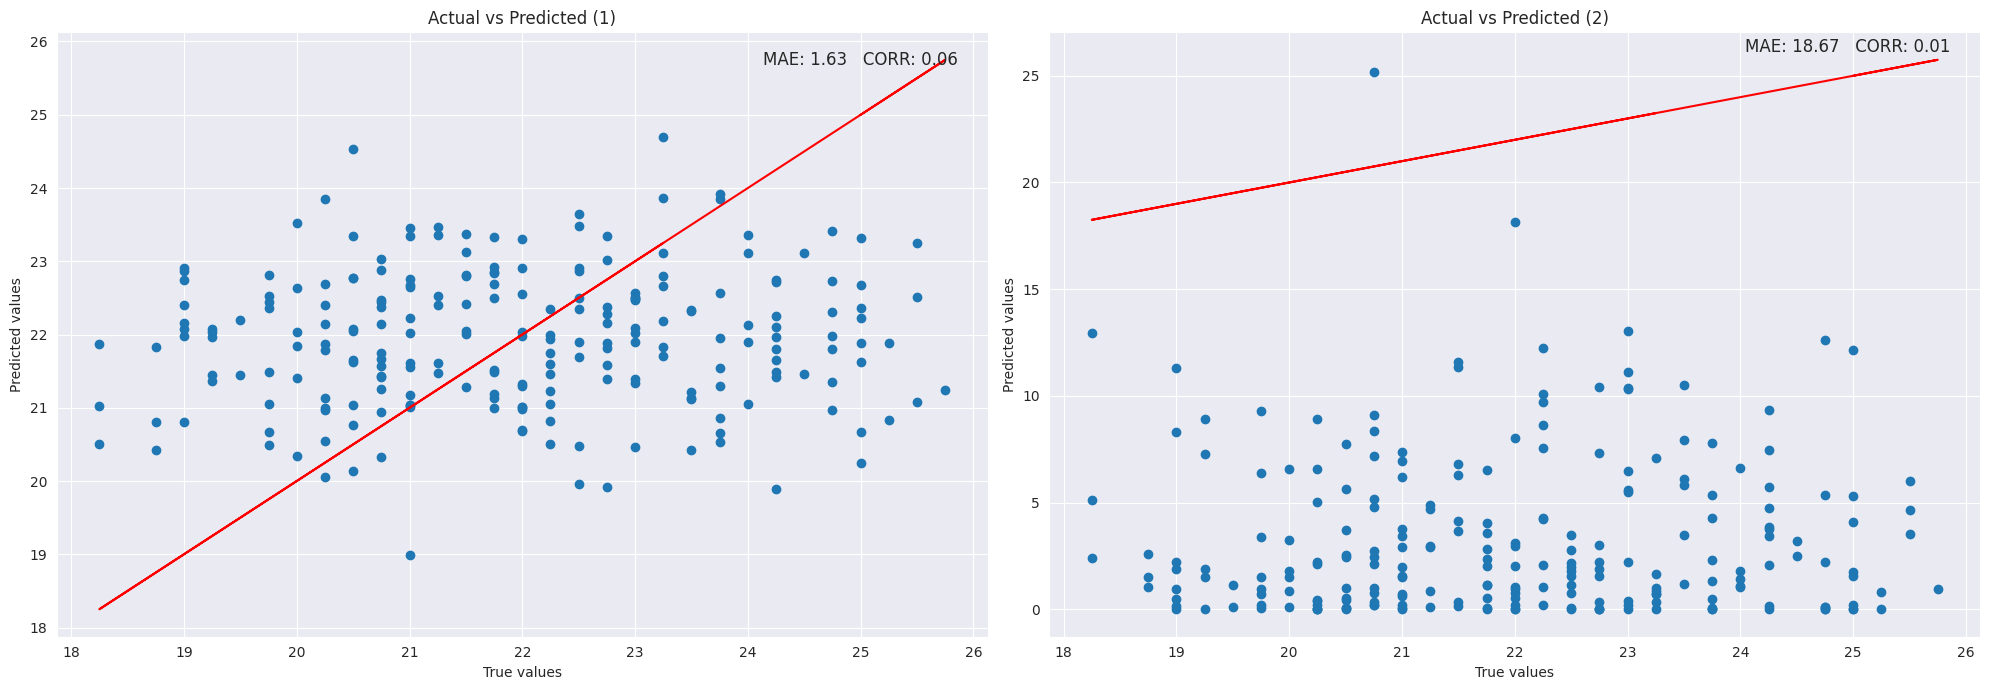

In [29]:
return_preds(inspector_hists_ridge,inspector_hists_gauss)